In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X_train = pd.read_csv("../Data/Processed/X_train.csv")
X_test  = pd.read_csv("../Data/Processed/X_test.csv")
# squeeze  making them a series/1D
y_train = pd.read_csv("../Data/Processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../Data/Processed/y_test.csv").squeeze()



X = X_train
y = y_train

numeric_cols = [
    "Administrative", "Informational","ProductRelated", "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration","BounceRates","ExitRates","SpecialDay",
]

# Fit the scaler on training numerics only then replace those columns in X
scaler = StandardScaler()
X[numeric_cols] = pd.DataFrame(
    scaler.fit_transform(X[numeric_cols]),
    columns=numeric_cols,
    index=X.index
).astype(float)


# class weight balanced counters the class imbalance (giving buyer errors more weight)
logr = LogisticRegression(class_weight='balanced', max_iter=200, random_state=42)
logr.fit(X, y)

print("Intercept:", logr.intercept_)
print("Coefficients shape:", logr.coef_.shape)



Intercept: [-0.59808947]
Coefficients shape: (1, 58)


Confusion matrix:
 [[1227  857]
 [ 114  268]]

Classification report:
               precision    recall  f1-score   support

       False      0.915     0.589     0.716      2084
        True      0.238     0.702     0.356       382

    accuracy                          0.606      2466
   macro avg      0.577     0.645     0.536      2466
weighted avg      0.810     0.606     0.661      2466

ROC–AUC: 0.706

Threshold comparison (Precision, Recall, F1):
Threshold 0.1: Precision=0.176, Recall=0.990, F1=0.298
Threshold 0.2: Precision=0.188, Recall=0.966, F1=0.315
Threshold 0.3: Precision=0.200, Recall=0.919, F1=0.329
Threshold 0.4: Precision=0.215, Recall=0.822, F1=0.341
Threshold 0.5: Precision=0.238, Recall=0.702, F1=0.356
Threshold 0.6: Precision=0.273, Recall=0.526, F1=0.359
Threshold 0.7: Precision=0.322, Recall=0.275, F1=0.297
Threshold 0.8: Precision=0.507, Recall=0.089, F1=0.151


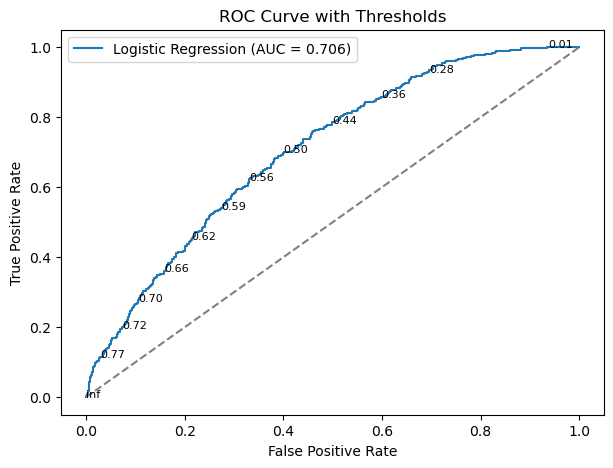

In [2]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# Scale numeric columns in the TEST set using the SAME scaler 
# fit_transform was done on training, so now we only transform test
X_test[numeric_cols] = pd.DataFrame(
    scaler.transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
).astype(float)

# Predict probabilities and class labels
# predict_proba gives both classes; we take [:,1] for the probability of purchase (Revenue=1)
y_proba = logr.predict_proba(X_test)[:, 1]
# default threshold of 0.5 to classify purchase vs no-purchase
y_pred = (y_proba >= 0.5).astype(int)

#  Basic evaluation metrics
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC–AUC:", round(roc_auc_score(y_test, y_proba), 3))

# Threshold exploring
thresholds = np.arange(0.1, 0.9, 0.1)
print("\nThreshold comparison (Precision, Recall, F1):")
for t in thresholds:
    preds_t = (y_proba >= t).astype(int)
    precision = precision_score(y_test, preds_t)
    recall = recall_score(y_test, preds_t)
    f1 = f1_score(y_test, preds_t)
    print(f"Threshold {t:.1f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

# ROC curve plot
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, y_proba):.3f})")

# Add threshold labels at every 10th point to avoid clutter
for i in range(0, len(thresholds), 50):
    plt.text(fpr[i], tpr[i], f"{thresholds[i]:.2f}", fontsize=8)

plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Thresholds")
plt.legend()
plt.show()

